# Temperaturas Ciudades

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime
from math import *
from util import *
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

plt.rcParams["figure.figsize"] = (16, 10)

In [2]:
#ciudades = df.query('city == "Akron" | city == "Cincinnati"')
#ciudad = df.query('city == "Lincoln"')

#dfjoinCiudades = df.query('city == "Cincinnati"').join(df.query('city == "Akron"').set_index("ordinal"), on='ordinal', lsuffix='_cin', rsuffix='_akr_')
#ciudad = df.query('city == "Lincoln"')
#df[df["date"] > datetime(1999,1,1)].pivot("city", "avg")

In [2]:
#Se predice por año, NO MES, se hace un avg del año

def dataFrameEnFecha(df, year, qtty):
    """ Devuelve un dataframe desde year hasta year+qtty
    """
    df = df[df['year'] >= year]
    return df[df['year'] < year+qtty]


def pasoComunGenDF(df, calAvg):
    listCities = list(set(df['city']))
    listCitiesQuery = list(set(df['city']))
    for i in range(len(listCitiesQuery)):
        listCitiesQuery[i] = '"' + listCitiesQuery[i] + '"'

    dicCities = {}
    for i in range(len(listCities)):
        #Genero un nuevo dataframe, calculo el avg anual y elimino las filas duplicadas del año y columna 'avg'
        dfCity = pd.DataFrame(df.query('city == ' + listCitiesQuery[i]))

        if(calAvg):
            listAvgYr = list(dfCity.groupby('year').apply(lambda x: x.sum()/12)['avg'])
            dfCity.drop_duplicates(subset='year', inplace=True)
            del dfCity['avg']
            dfCity['avg'] = listAvgYr

        #Agrego el dataframe a un dic
        dicCities[listCities[i]] = dfCity
    
    return dicCities


def genDFAvgYr(df):
    """ Devuelve un dataframe que tiene solo promedio anual
    """
    dicCities = pasoComunGenDF(df, True)
    valDf = list(dicCities.values())
    return pd.concat(valDf)


def generarDFXS(df, varList):
    """ Genero un dataframe con los xs para pasarle a la funcion
    """
    dicCities = pasoComunGenDF(df, False)

    #Genero el dataframe para retornar
    yearCol = list(set(df['year']))
    dfXs = pd.DataFrame()
    for k,v in dicCities.items():
        for c in varList:
            dfXs[c+ " " + k] = list(v[c])
    dfXs['year'] = yearCol
    
    return dfXs


def getListXS(df):
    temp=[]
    for row in df.iterrows():
        index, data = row
        temp.append(data.tolist())
    return [data for index, data in df.iterrows()]


def resolver(dfCity, dfLotOfCities, yrFromT, qttyYrFromT, yrFromP, qttyYrFromP, funcion):
    #TRAINING
    dfCityT = dfCity.copy(deep=True)
    dfLotOfCitiesT = dfLotOfCities.copy(deep=True)
    #me quedo con los df de la fecha que necesito
    dfCityT = dataFrameEnFecha(dfCityT, yrFromT, qttyYrFromT)
    dfLotOfCitiesT = dataFrameEnFecha(dfLotOfCitiesT, yrFromT, qttyYrFromT)
    fechasT = list(dfLotOfCitiesT['year'])

    #Con esto genero una lista con los x para pasarle a cml
    xsT = dfLotOfCitiesT.values.tolist()
    ysT = list(dfCityT['avg'])

    funCML = cml(funcion, xsT, ysT)
    resXST = [funCML(x) for x in xsT]

    #PREDICTION
    dfCityP = dfCity.copy(deep=True)
    dfLotOfCitiesP = dfLotOfCities.copy(deep=True)
    #me quedo con los df de la fecha que necesito
    dfCityP = dataFrameEnFecha(dfCityP, yrFromP, qttyYrFromP)
    dfLotOfCitiesP = dataFrameEnFecha(dfLotOfCitiesP, yrFromP, qttyYrFromP)
    fechasP = list(dfLotOfCitiesP['year'])

    xsP = dfLotOfCitiesP.values.tolist()
    ysP = list(dfCityP['avg'])
    resXSP = [funCML(x) for x in xsP]
    
    return (fechasT, xsT, ysT, resXST, fechasP, xsP, ysP, resXSP)


def calcularDatosEnChunks(dfCity, dfLotOfCities, yrFrom, yrsPerChunk, yrStop, qttyYsToPredict, funcion):
    dicChunks = {}
    qttyYrs = yrStop - yrFrom
    yrs = 0
    nbrChunk = 0
    while qttyYrs > 0:
        yrs += yrsPerChunk
        if yrs + yrFrom > yrStop:
            yrs -= yrsPerChunk
            aux = yrs
            yrs = yrStop - (yrFrom+yrs)
            yrs += aux
        dicChunks["chunk " + str(nbrChunk)] = resolver(dfCity, dfLotOfCities, yrFrom, yrs, yrFrom+yrs+1, qttyYsToPredict, funcion)
        qttyYrs -= yrsPerChunk
        nbrChunk += 1
    return dicChunks


def funcForPlot(x, y, **kwargs):
    palette = sns.color_palette('Paired', 12)
    data = kwargs.pop('data')
    
    plt.plot(list(data['fechasT'])[0], list(data['ysT'])[0], 'o', label='Entrenamiento', markersize=4, color=palette[0])
    plt.plot(list(data['fechasT'])[0], list(data['resXST'])[0], 'r', label='CML', color=palette[1])
    plt.plot(list(data['fechasP'])[0], list(data['ysP'])[0], 'o', label='Real', markersize=6, color=palette[5])
    plt.plot(list(data['fechasP'])[0], list(data['resXSP'])[0], 'X', label='Predicción', markersize=6, color=palette[7])
    #calculo ecm
    err = ecm(list(data['resXSP'])[0], list(data['ysP'])[0])
    print('error chunk <= {} -> {}'.format(list(data['chunk'])[0], err))

In [3]:
#LEVANTO DATOS
dfWest = pd.read_csv('data/CitiesWestChunk.csv', parse_dates = [0])
dfEast = pd.read_csv('data/CitiesEastChunk.csv', parse_dates = [0])
dfWest.sort_values(['date','country','city'], inplace = True)
dfEast.sort_values(['date','country','city'], inplace = True)

#ME QUEDO CON LOS DATOS DE FECHAS COMUNES EN TODAS
#Datos de 1849 a 2013
minWest = dfWest.groupby("city", as_index=False)["date"].aggregate(["min","max"])["min"].aggregate("max")
maxWest = dfWest.groupby("city", as_index=False)["date"].aggregate(["min","max"])["max"].aggregate("min")
minEast = dfEast.groupby("city", as_index=False)["date"].aggregate(["min","max"])["min"].aggregate("max")
maxEast = dfEast.groupby("city", as_index=False)["date"].aggregate(["min","max"])["max"].aggregate("min")
minTotal = max(minWest, minEast)
maxTotal = min(maxWest, maxWest)
dfWest = dfWest[dfWest['date'] >= minTotal]
dfWest = dfWest[dfWest['date'] < maxTotal]
dfEast = dfEast[dfEast['date'] >= minTotal]
dfEast = dfEast[dfEast['date'] < maxTotal]

#dfWest['ordinal']= dfWest['date'].apply(lambda x: x.toordinal())
dfWest["year"] = dfWest["date"].apply(lambda d: d.year)
#dfEast['ordinal']= dfEast['date'].apply(lambda x: x.toordinal())
dfEast["year"] = dfEast["date"].apply(lambda d: d.year)

#Genero promedio anual y quito promedio mensual
dfWest = genDFAvgYr(dfWest)
dfEast = genDFAvgYr(dfEast)

groupByCitiesW = dfWest.groupby('city')
groupByCitiesE = dfEast.groupby('city')

In [5]:
#funcion lineal cabeza, probar otras
#me hago un df para un ordinal tener todas las temperaturas de todas las ciudades (altitud tambien?)

In [4]:
#Para cada w in CitiesW, calcular(w, CitiesE)
#Para cada e in CitiesE, calcular(e, CitiesW)
listCitiesWest = list(set(dfWest['city']))
listCitiesEast = list(set(dfEast['city']))
listXs = ['avg','altitude','year']
dfW = generarDFXS(dfWest, listXs)
dfE = generarDFXS(dfEast, listXs)
print('West Cities:')
print(listCitiesWest)
print('East Cities')
print(listCitiesEast)

West Cities:
['Seattle', 'Portland', 'Henderson', 'Glendale', 'San Francisco', 'Santa Ana', 'Mesa', 'Oakland', 'Modesto', 'Long Beach', 'Stockton', 'San Diego', 'Chula Vista', 'Sacramento', 'Los Angeles', 'Riverside', 'Fresno', 'Tucson', 'Phoenix', 'San Jose', 'Las Vegas', 'Paradise', 'Bakersfield', 'Albuquerque', 'Anaheim', 'Chandler', 'Scottsdale', 'El Paso']
East Cities
['Pittsburgh', 'Toledo', 'Greensboro', 'Jacksonville', 'Jersey City', 'Washington', 'Akron', 'Miami', 'Newark', 'Orlando', 'Detroit', 'Raleigh', 'Norfolk', 'Arlington', 'Charlotte', 'Atlanta', 'Tampa', 'Buffalo', 'Virginia Beach', 'Baltimore', 'Rochester', 'Philadelphia', 'Durham', 'Boston', 'Columbus', 'Saint Petersburg', 'Hialeah', 'Cleveland']


In [13]:
#prueba para ver si la funcion anda, quitar despues
idxCity = 2

dfCity = groupByCitiesW.get_group(listCitiesWest[idxCity])
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

fechasT, xsT, ysT, resXST, fechasP, xsP, ysP, resXSP = resolver(dfCity, dfe, 1970, 25, 1995, 5, funcion)

#LO COMENTE PORQUE NO QUIERO QUE PLOTEE

#plt.plot(fechasT, resXST, 'r', label='East Cities Training', color='red')
#plt.plot(fechasP, resXSP, 'r', label='East Cities Prediction', color='green')

#plt.plot(fechasT+fechasP, ysT+ysP, 'o', label=listCitiesWest[idxCity]+': Real', markersize=10, color='blue')

#plt.title('{} | ECM = {} '.format("Predecir "+ listCitiesWest[idxCity], 'lol') )
#plt.legend()
#plt.show()

ECM TOTAL Promedio 0.550795833574
error chunk <= 0 -> 0.6365930475806062
error chunk <= 1 -> 1.610076097008593
error chunk <= 2 -> 0.38289639000584225
error chunk <= 3 -> 0.8603658150459724
error chunk <= 4 -> 0.5204801206905583
error chunk <= 5 -> 0.11520564827388707
error chunk <= 6 -> 0.04411556838058531
error chunk <= 7 -> 0.227678869109336
error chunk <= 8 -> 0.1226914114121053
error chunk <= 9 -> 0.4105070004498296
error chunk <= 10 -> 0.5098180209427234


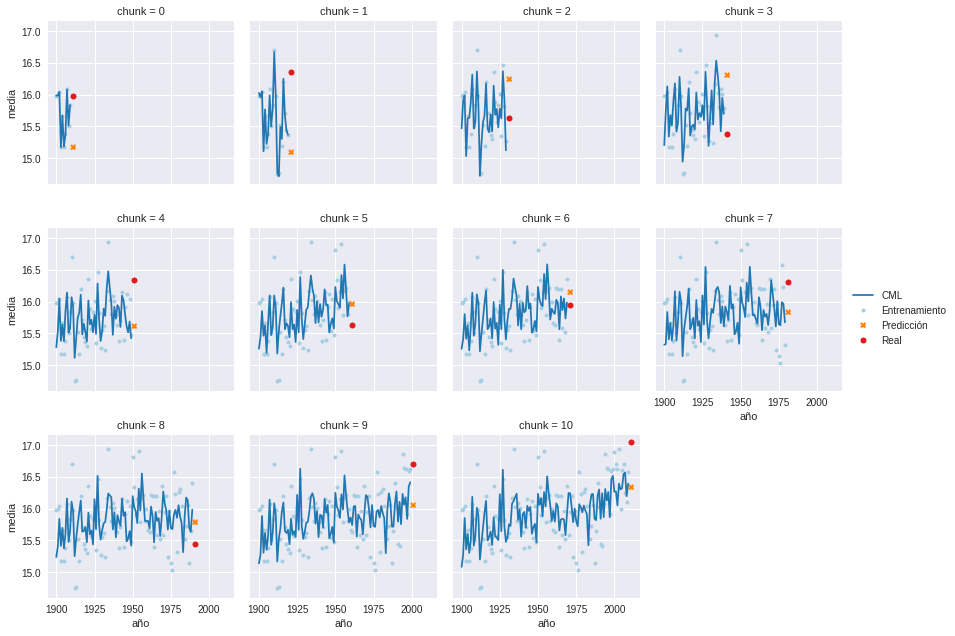

In [12]:
# TEST
# Pruebo si puedo predecir la ciudad del oeste 'El Paso' con las del Este.
# Desde 1900 hasta 2010 tomando chunks de 10 años y prediciendo el siguiente.
# Variables -> avg, altitude, year
# funcion lineal

ciudadWest = 'El Paso'
dfCity = groupByCitiesW.get_group(ciudadWest)
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfe, 1900, 10, 2010, 1, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfe, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
# si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 0.292238890439
error chunk <= 0 -> 0.0038115329109392818
error chunk <= 1 -> 0.8803837831176763
error chunk <= 2 -> 0.5108042486232341
error chunk <= 3 -> 0.2043064530968375
error chunk <= 4 -> 0.0027714173311711348
error chunk <= 5 -> 0.7353855880651731
error chunk <= 6 -> 0.0187011717959637
error chunk <= 7 -> 0.1668196774616329
error chunk <= 8 -> 0.07263270420081257
error chunk <= 9 -> 0.7374945342168299
error chunk <= 10 -> 1.004458711464151


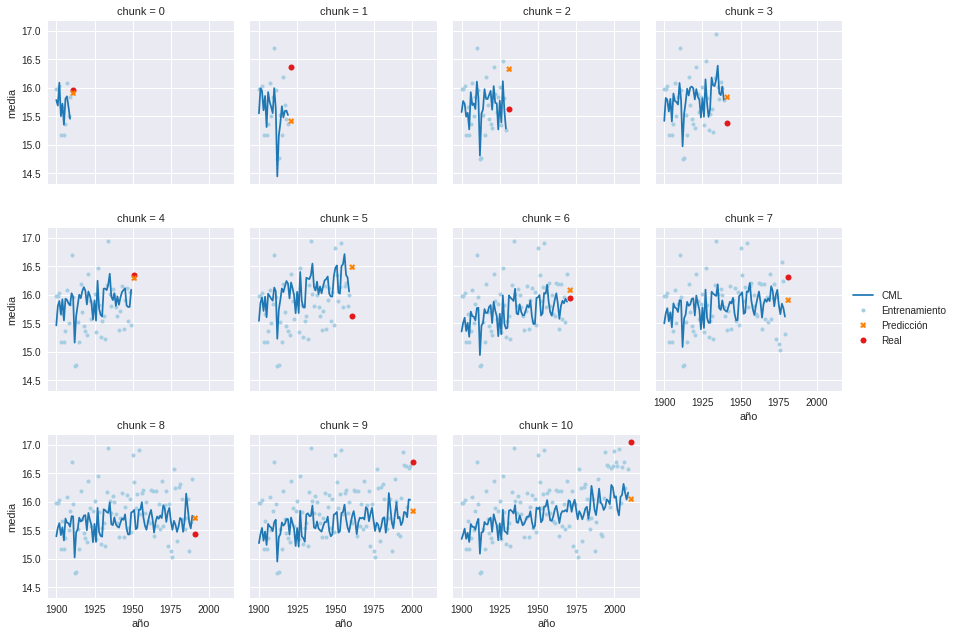

In [11]:
# TEST
# Pruebo si puedo predecir la ciudad del oeste 'El Paso' con las del Este.
# Desde 1900 hasta 2010 tomando chunks de 10 años y prediciendo el siguiente.
# Variables -> avg, altitude, year
# funcion variables a la 7

ciudadWest = 'El Paso'
dfCity = groupByCitiesW.get_group(ciudadWest)
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i]**7 for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfe, 1900, 10, 2010, 1, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfe, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 0.550795833574
error chunk <= 0 -> 0.6451306374511246
error chunk <= 1 -> 1.1678523195325556
error chunk <= 2 -> 0.20437121024557134
error chunk <= 3 -> 0.30114780284310516
error chunk <= 4 -> 0.2392730626400573
error chunk <= 5 -> 0.05333531064181655
error chunk <= 6 -> 0.1613656351602474
error chunk <= 7 -> 0.19967979853410442
error chunk <= 8 -> 0.24678312665340152
error chunk <= 9 -> 0.5701502163689726
error chunk <= 10 -> 15.678061489168721


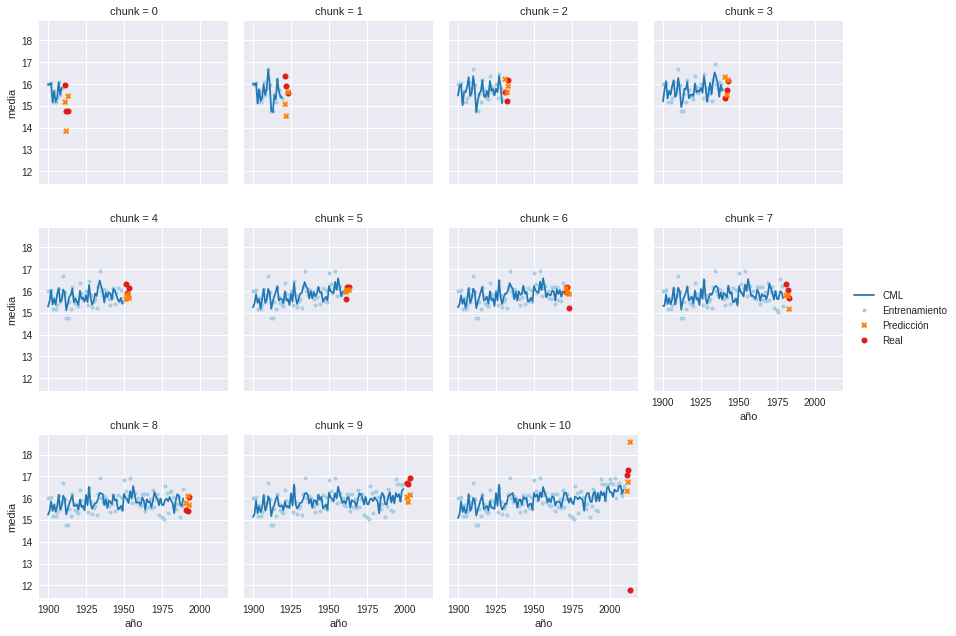

In [10]:
# TEST
# Pruebo si puedo predecir la ciudad del oeste 'El Paso' con las del Este.
# Variables -> avg, altitude, year
# funcion variables a la 1
# Tomando el test anterior veo si puedo predecir 3 años en vez de 1

ciudadWest = 'El Paso'
dfCity = groupByCitiesW.get_group(ciudadWest)
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfe, 1900, 10, 2010, 3, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfe, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 0.292238890439
error chunk <= 0 -> 0.06690594147277838
error chunk <= 1 -> 0.5336832018295463
error chunk <= 2 -> 0.4018190322644777
error chunk <= 3 -> 0.09420893396292833
error chunk <= 4 -> 0.05039786768684639
error chunk <= 5 -> 0.33261133013353755
error chunk <= 6 -> 0.2651058711117611
error chunk <= 7 -> 0.06867869572759781
error chunk <= 8 -> 0.1319731091744365
error chunk <= 9 -> 1.4216168613236977
error chunk <= 10 -> 8.43646711218281


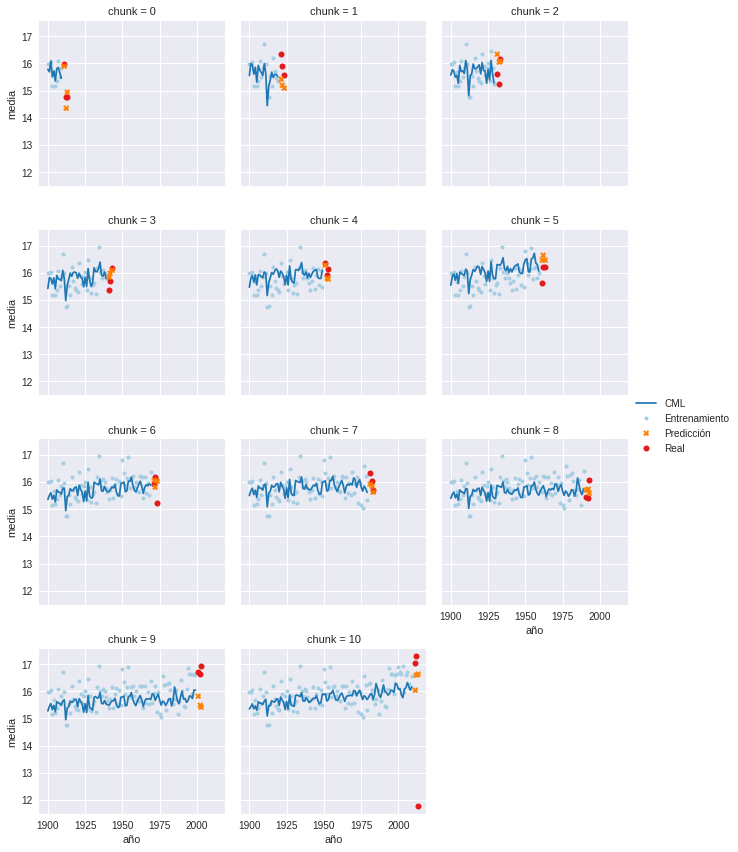

In [9]:
# TEST
# Pruebo si puedo predecir la ciudad del oeste 'El Paso' con las del Este.
# Variables -> avg, altitude, year
# funcion variables a la 7
# Tomando el test anterior veo si puedo predecir 3 años en vez de 1

ciudadWest = 'El Paso'
dfCity = groupByCitiesW.get_group(ciudadWest)
dfe = dfE.copy(deep=True)
funcion = lambda xs: [xs[i]**7 for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfe, 1900, 10, 2010, 3, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfe, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

l = sns.FacetGrid(df2, col="chunk", col_wrap=3, size=3)
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año')\
    .set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 1.67485290153
error chunk <= 0 -> 4.314396050442074
error chunk <= 1 -> 0.002313790608572102
error chunk <= 2 -> 2.1159909450915264
error chunk <= 3 -> 0.26658809090548635
error chunk <= 4 -> 0.06483386837499908
error chunk <= 5 -> 0.012044720119045404
error chunk <= 6 -> 0.02013735629130705
error chunk <= 7 -> 0.011917776336062625
error chunk <= 8 -> 2.0778630490677243
error chunk <= 9 -> 0.27770221913477444
error chunk <= 10 -> 0.03549871158068574


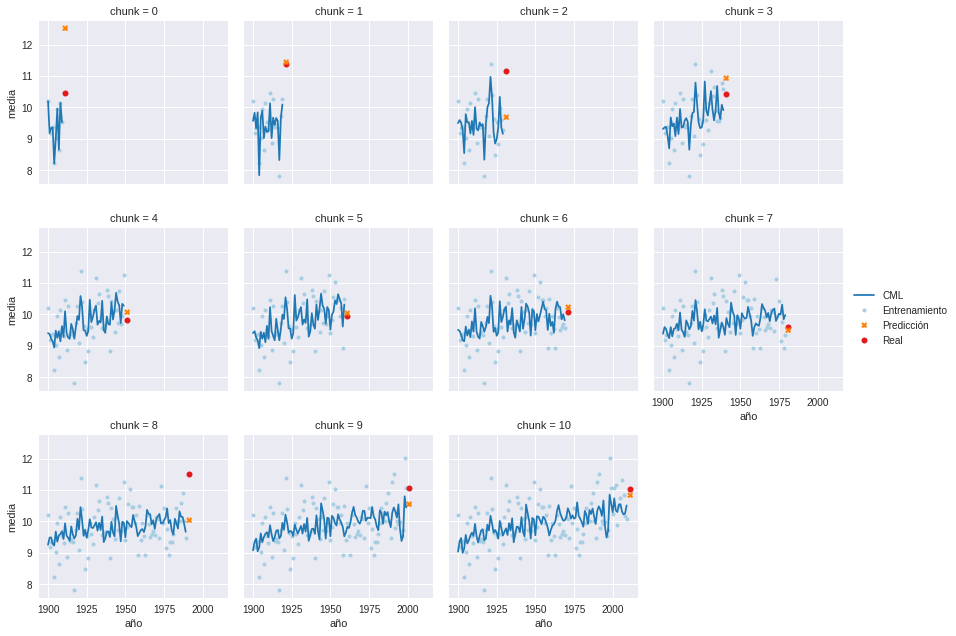

In [8]:
# TEST
# Pruebo si puedo predecir la ciudad del este 'Cleveland' con las del Oeste.
# Desde 1900 hasta 2010 tomando chunks de 10 años y prediciendo el siguiente.
# Variables -> avg, altitude, year
# funcion lineal

ciudadEast = 'Cleveland'
dfCity = groupByCitiesE.get_group(ciudadEast)
dfw= dfW.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfw, 1900, 10, 2010, 1, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfw, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 10.1149372529
error chunk <= 0 -> 1.403508623103385
error chunk <= 1 -> 4.582592533946591
error chunk <= 2 -> 4.52201096155368
error chunk <= 3 -> 0.0990800806487147
error chunk <= 4 -> 0.36505285692232237
error chunk <= 5 -> 0.17149223110742368
error chunk <= 6 -> 0.03539919452547167
error chunk <= 7 -> 0.0033502189200672956
error chunk <= 8 -> 1.8138684389171291
error chunk <= 9 -> 0.8232896772874273
error chunk <= 10 -> 0.11050217133149323


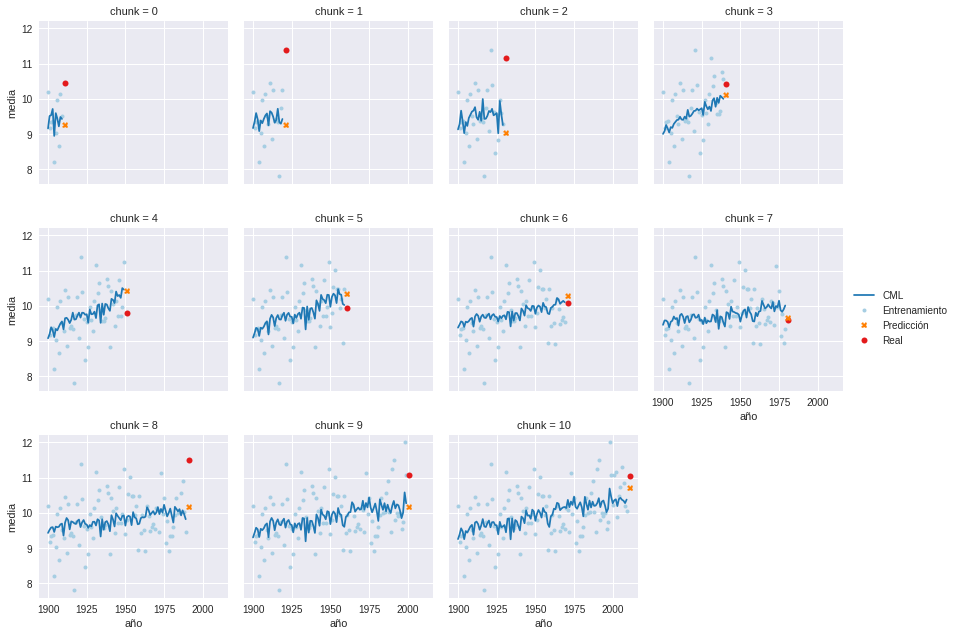

In [7]:
# TEST
# Pruebo si puedo predecir la ciudad del este 'Cleveland' con las del Oeste.
# Desde 1900 hasta 2010 tomando chunks de 10 años y prediciendo el siguiente.
# Variables -> avg, altitude, year
# funcion: variables a la 7

ciudadEast = 'Cleveland'
dfCity = groupByCitiesE.get_group(ciudadEast)
dfw= dfW.copy(deep=True)
funcion = lambda xs: [xs[i]**7 for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfw, 1900, 10, 2010, 1, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfw, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 1.67485290153
error chunk <= 0 -> 11.872959833969924
error chunk <= 1 -> 0.770049231690337
error chunk <= 2 -> 1.6204381084561668
error chunk <= 3 -> 0.6092281175187312
error chunk <= 4 -> 0.25469865200697983
error chunk <= 5 -> 0.9896465201178192
error chunk <= 6 -> 1.2247307171562634
error chunk <= 7 -> 0.16029585643131367
error chunk <= 8 -> 0.7585796392098546
error chunk <= 9 -> 0.4374084303682233
error chunk <= 10 -> 10.80505339350148


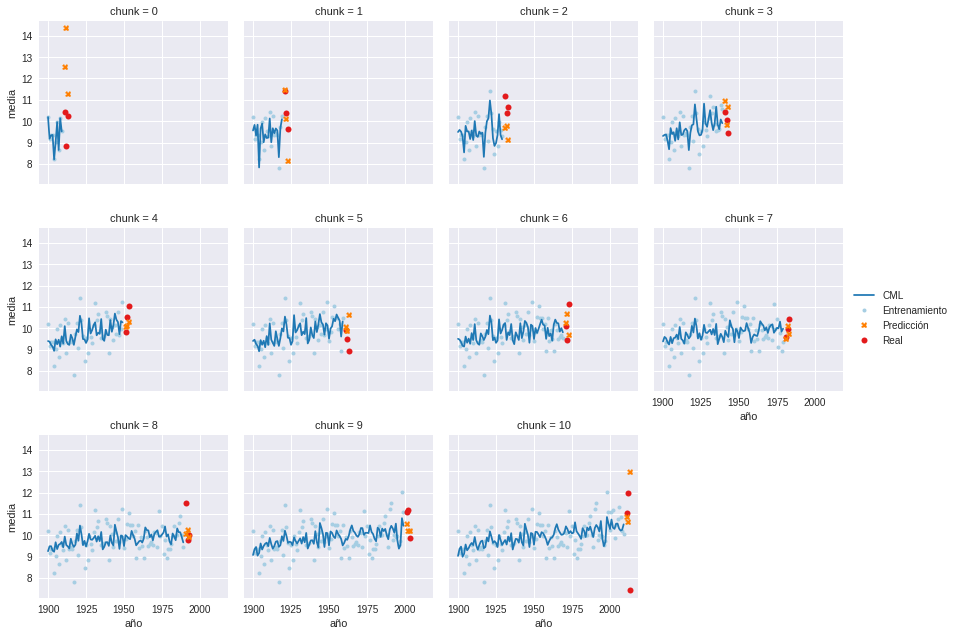

In [6]:
# TEST
# Pruebo si puedo predecir la ciudad del este 'Cleveland' con las del Oeste.
# Desde 1900 hasta 2010 tomando chunks de 10 años y los siguientes 3.
# Variables -> avg, altitude, year
# funcion lineal

ciudadEast = 'Cleveland'
dfCity = groupByCitiesE.get_group(ciudadEast)
dfw= dfW.copy(deep=True)
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfw, 1900, 10, 2010, 3, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfw, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()

ECM TOTAL Promedio 10.1149372529
error chunk <= 0 -> 1.1715820636818801
error chunk <= 1 -> 1.8632691648286064
error chunk <= 2 -> 1.8779269434122172
error chunk <= 3 -> 0.2583817726803774
error chunk <= 4 -> 0.22059750113498663
error chunk <= 5 -> 1.1188486985714148
error chunk <= 6 -> 0.4219375258536637
error chunk <= 7 -> 0.07013136758016315
error chunk <= 8 -> 0.6306012674594387
error chunk <= 9 -> 0.6014634019063722
error chunk <= 10 -> 6.5195457862174235


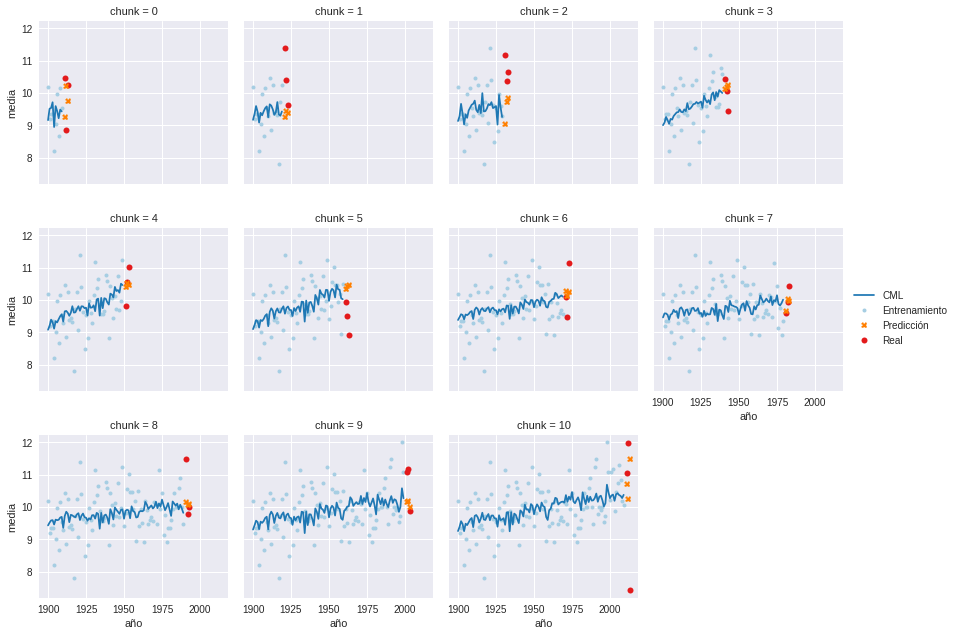

In [5]:
# TEST
# Pruebo si puedo predecir la ciudad del este 'Cleveland' con las del Oeste.
# Desde 1900 hasta 2010 tomando chunks de 10 años y prediciendo los siguientes 3.
# Variables -> avg, altitude, year
# funcion: variables a la 7

ciudadEast = 'Cleveland'
dfCity = groupByCitiesE.get_group(ciudadEast)
dfw= dfW.copy(deep=True)
funcion = lambda xs: [xs[i]**7 for i in range(len(xs))] + [1]

dicChunks = calcularDatosEnChunks(dfCity, dfw, 1900, 10, 2010, 3, funcion)

df2 = pd.DataFrame(dicChunks).T
df2.columns = ['fechasT', 'xsT', 'ysT', 'resXST', 'fechasP', 'xsP', 'ysP', 'resXSP']

# Agrego una columna de enteros al dataframe para poder pasarsela al facetGrid sino tira error
df2.sort_values(['fechasP'], inplace=True)
chunkList = []
for i in range(len(list(df2['fechasP']))):
    chunkList.append(i)
df2['chunk'] = chunkList

# Calculo el ECM Promedio de todos
dicECM = calcularDatosEnChunks(dfCity, dfw, 1900, 1, 2010, 1, funcion)
ecmProm = 0
for k,v in dicECM.items():
    ecmProm += ecm(v[7], v[6])
ecmProm = ecmProm/len(dicECM)
print("ECM TOTAL Promedio", ecmProm)

l = sns.FacetGrid(df2, col="chunk", col_wrap=4, size=3)
l.map_dataframe(funcForPlot, 'fechasT', 'resXST').set_xlabels('año').set_ylabels('media')
#si add_legend() no esta despues de map_dataframe() no lo agrega
l.add_legend()